# 提取日期

如按自然日处理，最终统计的是2017到2024都为交易日的日期

In [ ]:
import pandas as pd
import pandas_market_calendars as pmc

# 1) 交易日历
sh = pmc.get_calendar('XSHG')
schedule = sh.schedule(start_date='2017-01-01', end_date='2025-12-31')
trade_days = schedule.index.normalize()         # DatetimeIndex（日期级）
trade_days_set = set(trade_days)                # O(1) 查询

# 2) 原始数据 -> 按年字典，并把 date 设为索引
df_raw = pd.read_excel('中债国债到期收益率_10年.xlsx')
df_raw['date'] = pd.to_datetime(df_raw['date']).dt.normalize()
df_raw = df_raw.sort_values('date')

df_by_year = {
    y: g.set_index('date').sort_index()
    for y, g in df_raw.groupby(df_raw['date'].dt.year)
}

# 可选：在原 df 上标注是否交易日
df_raw['is_trade_day'] = df_raw['date'].isin(trade_days)

In [ ]:
# 3) 非交易日对齐（选用“对齐到下一个交易日”；你也可以改成上一个：method='pad'）
def align_to_next_trade_day(ts: pd.Timestamp, trade_idx: pd.DatetimeIndex):
    ts = pd.Timestamp(ts).normalize()
    pos = trade_idx.searchsorted(ts)  # >= ts 的第一个交易日位置
    if pos >= len(trade_idx):
        return None
    return trade_idx[pos]

# 4) 计算收益
def calculate_profit(df_by_year: dict, start_date: pd.Timestamp, end_date: pd.Timestamp,
                     trade_idx: pd.DatetimeIndex, strict=False):
    # 标准化
    start_date = pd.Timestamp(start_date).normalize()
    end_date = pd.Timestamp(end_date).normalize()

    if strict:
        # 严格要求当天必须是交易日
        if (start_date not in trade_days_set) or (end_date not in trade_days_set):
            return None, None
    else:
        # 自动对齐到最近的“下一个”交易日（也可改成上一个）
        start_date = align_to_next_trade_day(start_date, trade_idx)
        end_date = align_to_next_trade_day(end_date, trade_idx)
        if (start_date is None) or (end_date is None):
            return None, None

    try:
        s = df_by_year[start_date.year].loc[start_date, 'yield']
        e = df_by_year[end_date.year].loc[end_date, 'yield']
    except KeyError:
        # 某年的该交易日数据里缺失（比如债券收益率缺一行）
        return None, None

    return float(e - s), int((end_date - start_date).days)

# 5) 获取结束日期
def get_end_date(start_date:pd.Timestamp, length:int) -> pd.Timestamp:
    """获取从 start_date 开始，长度为 length 天的结束日期"""
    start_date = pd.Timestamp(start_date).normalize()
    return start_date + pd.Timedelta(days=length)

# 6) 获取2017-2024的同日
def get_same_day_in_years(start_date: pd.Timestamp) -> list:
    """获取 start_date 在指定年份的同日"""
    years = [2017,2018,2019,2020,2021,2022,2023,2024]
    start_date = pd.Timestamp(start_date).normalize()
    return [pd.Timestamp(f"{y}-{start_date.month:02d}-{start_date.day:02d}") for y in years]

# 7) 主脚本
seq_length = [3, 10, 15, 30, 60, 90]
for length in seq_length:
    print(f"Length: {length} days")
    for start_date in get_same_day_in_years('2017-01-01'):
        end_date = get_end_date(start_date, length)
        profit, days = calculate_profit(df_by_year, start_date, end_date, trade_days, strict=False)
        if profit is not None:
            print(f"From {start_date.date()} to {end_date.date()}: Profit={profit:.2f}, Days={days}")
        else:
            print(f"From {start_date.date()} to {end_date.date()}: No data available")

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import pandas_market_calendars as pmc

# ========= 0) 读数据 & 交易日历 =========
DATA_FILE = '中债国债到期收益率_10年.xlsx'   # 两列：date, yield

df_raw = pd.read_excel(DATA_FILE)
df_raw['date'] = pd.to_datetime(df_raw['date']).dt.normalize()
df_raw = df_raw.sort_values('date')

# 按年分表，并把 date 设为索引
df_by_year = {
    y: g.set_index('date').sort_index()
    for y, g in df_raw.groupby(df_raw['date'].dt.year)
}

# 交易日历（XSHG；如需银行间可替换为自建日历）
cal = pmc.get_calendar('XSHG')
trade_idx = cal.schedule(start_date='2017-01-01', end_date='2025-12-31').index.normalize()
trade_idx = pd.DatetimeIndex(trade_idx)      # 保证是 DatetimeIndex
trade_set = set(trade_idx)                   # O(1) 查询

# ========= 1) 工具函数 =========
def align_to_next_trade_day(ts: pd.Timestamp, trade_idx: pd.DatetimeIndex):
    """对齐到 >= ts 的最近交易日；超出范围返回 None"""
    ts = pd.Timestamp(ts).normalize()
    pos = trade_idx.searchsorted(ts)
    if pos >= len(trade_idx):
        return None
    return trade_idx[pos]

def safe_make_date(year: int, month: int, day: int):
    """处理 2/29 等无效日期，返回 None 表示该年无此日期"""
    try:
        return pd.Timestamp(year=year, month=month, day=day)
    except ValueError:
        return None

def window_profit_one_year(y: int, start_md: tuple[int,int], length: int,
                           trade_idx: pd.DatetimeIndex):
    """
    给定某一年 y、起点“月日” start_md=(m,d) 和持有天数 length，
    计算该年的收益（自动对齐到下一个交易日）。返回 (profit, s_aligned, e_aligned)；若缺数据则 profit=None。
    """
    m, d = start_md
    s0 = safe_make_date(y, m, d)
    if s0 is None:
        return None, None, None

    e0 = s0 + pd.Timedelta(days=length)

    s = align_to_next_trade_day(s0, trade_idx)
    e = align_to_next_trade_day(e0, trade_idx)
    if (s is None) or (e is None):
        return None, None, None

    # 两端必须在各自年份的表中存在
    try:
        s_val = df_by_year[s.year].loc[s, 'yield']
        e_val = df_by_year[e.year].loc[e, 'yield']  # 可能跨年
    except KeyError:
        return None, None, None

    return float(e_val - s_val), s, e

def window_profit_multi_years(start_2017: pd.Timestamp, length: int,
                              years: list[int], trade_idx: pd.DatetimeIndex):
    """
    固定 2017 的某个起点（决定 month/day），在给定 years 列表中逐年复用“同月日 + 同 length”，
    计算可用年份的累计收益与使用年数，并记录每年对齐后的 (s,e) 以备落盘。
    """
    md = (pd.Timestamp(start_2017).month, pd.Timestamp(start_2017).day)
    total = 0.0
    used = 0
    path = []   # list[(year, s_aligned, e_aligned, profit)]
    for y in years:
        p, s, e = window_profit_one_year(y, md, length, trade_idx)
        if p is not None:
            total += p
            used += 1
            path.append((y, s, e, p))
    return (total if used > 0 else None), used, path

# ========= 2) 主流程：对 2017 年所有“日历日”遍历并保存 Top-10 与路径 =========
years_pool = list(range(2017, 2025))   # 2017–2024
seq_lengths = [3, 10, 15, 30, 60, 90]

# 用“日历日”更全面（非交易日会自动对齐）
all_2017_days = pd.date_range('2017-01-01', '2017-12-31', freq='D')

out_dir = Path('top10_windows_by_length')
out_dir.mkdir(parents=True, exist_ok=True)

for L in seq_lengths:
    rows = []
    detail_paths = []  # 收集 Top-10 的逐年轨迹（稍后填充）

    # 1) 全量候选起点评估
    for start in all_2017_days:
        total_profit, used_years, path = window_profit_multi_years(start, L, years_pool, trade_idx)
        if total_profit is None:
            continue
        end2017 = start + pd.Timedelta(days=L)
        rows.append({
            'length_days': L,
            'start_2017': start.date(),
            'end_2017': end2017.date(),
            'total_profit': total_profit,
            'avg_profit_per_year': total_profit / used_years if used_years > 0 else np.nan,
            'years_used': used_years
        })

    if not rows:
        print(f'[Length={L}] 没有可用窗口。')
        continue

    # 2) 排名&保存 Top-10
    df_rank = pd.DataFrame(rows).sort_values(['total_profit', 'years_used'], ascending=[False, False])
    top10 = df_rank.head(10).reset_index(drop=True)
    top_path = out_dir / f'top10_len_{L}.xlsx'
    top10.to_excel(top_path, index=False)
    print(f'[Length={L}] 已保存 Top-10 到: {top_path}')

    # 3) 基于 Top-10 重新计算逐年轨迹并保存 paths_len_{L}.xlsx
    for _, row in top10.iterrows():
        start_2017 = pd.Timestamp(row['start_2017'])
        total_profit, used_years, path = window_profit_multi_years(start_2017, L, years_pool, trade_idx)
        for (y, s, e, p) in path:
            detail_paths.append({
                'length_days': L,
                'start_2017': start_2017.date(),
                'year': y,
                'start_aligned': s.date() if s is not None else None,
                'end_aligned': e.date() if e is not None else None,
                'profit': p
            })

    paths_path = out_dir / f'paths_len_{L}.xlsx'
    pd.DataFrame(detail_paths).to_excel(paths_path, index=False)
    print(f'[Length={L}] 已保存逐年轨迹到: {paths_path}')

    # （可选）保存所有候选窗口的完整排行榜，便于热力图或后续分析
    # all_path = out_dir / f'all_windows_len_{L}.xlsx'
    # df_rank.to_excel(all_path, index=False)
    # print(f'[Length={L}] 已保存完整排行榜到: {all_path}')


[Length=3] 已保存 Top-10 到: top10_windows_by_length\top10_len_3.xlsx
[Length=3] 已保存逐年轨迹到: top10_windows_by_length\paths_len_3.xlsx
[Length=10] 已保存 Top-10 到: top10_windows_by_length\top10_len_10.xlsx
[Length=10] 已保存逐年轨迹到: top10_windows_by_length\paths_len_10.xlsx
[Length=15] 已保存 Top-10 到: top10_windows_by_length\top10_len_15.xlsx
[Length=15] 已保存逐年轨迹到: top10_windows_by_length\paths_len_15.xlsx
[Length=30] 已保存 Top-10 到: top10_windows_by_length\top10_len_30.xlsx
[Length=30] 已保存逐年轨迹到: top10_windows_by_length\paths_len_30.xlsx
[Length=60] 已保存 Top-10 到: top10_windows_by_length\top10_len_60.xlsx
[Length=60] 已保存逐年轨迹到: top10_windows_by_length\paths_len_60.xlsx
[Length=90] 已保存 Top-10 到: top10_windows_by_length\top10_len_90.xlsx
[Length=90] 已保存逐年轨迹到: top10_windows_by_length\paths_len_90.xlsx


[ok] 已保存：top10_windows_by_length\highlight_len_3.png


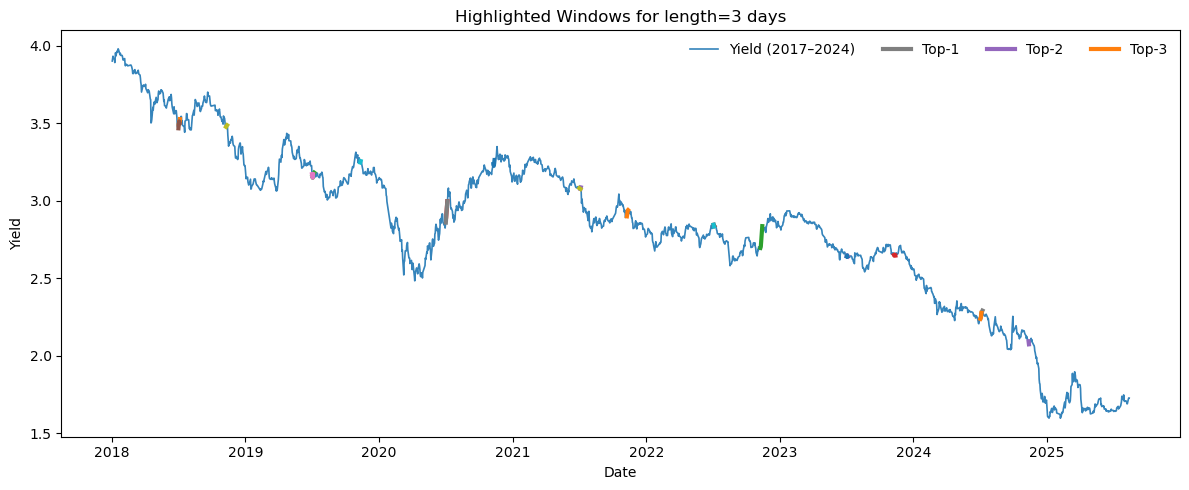

[ok] 已保存：top10_windows_by_length\highlight_len_10.png


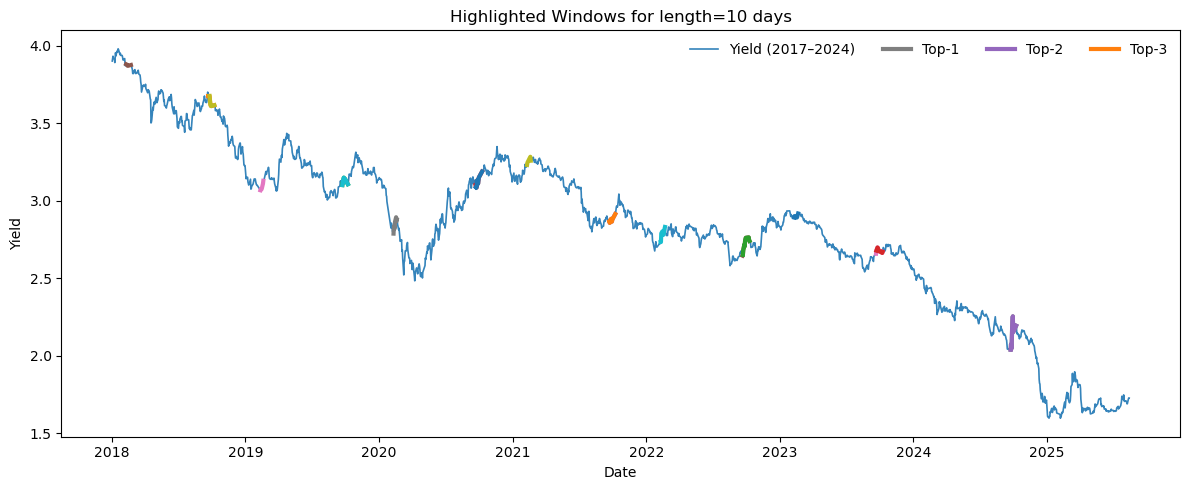

[ok] 已保存：top10_windows_by_length\highlight_len_15.png


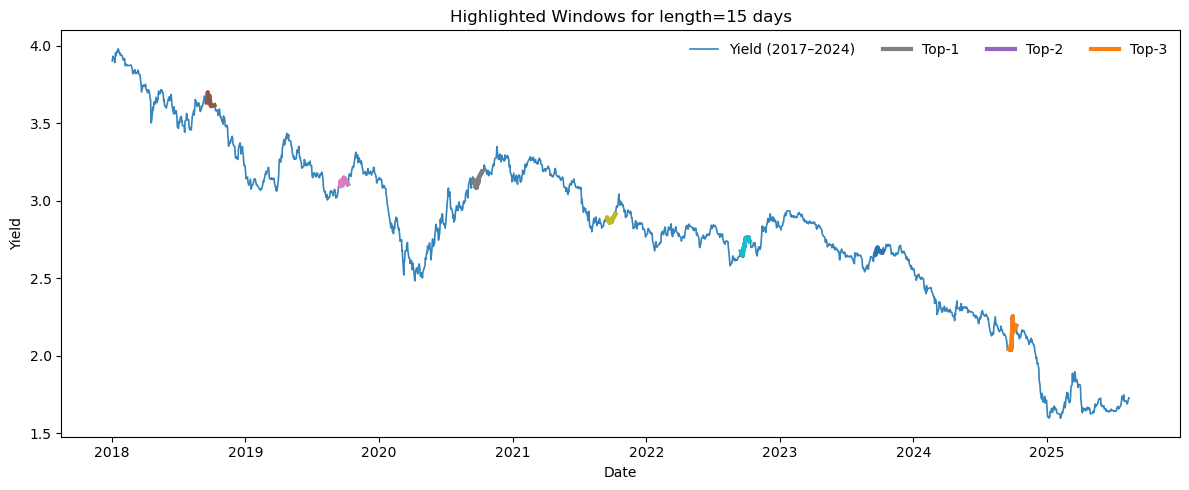

[ok] 已保存：top10_windows_by_length\highlight_len_30.png


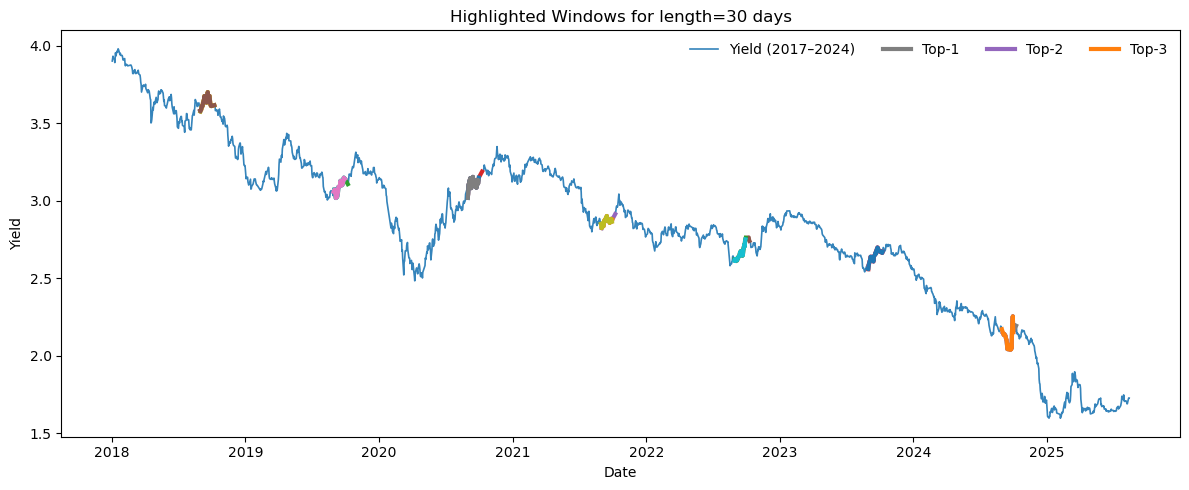

[ok] 已保存：top10_windows_by_length\highlight_len_60.png


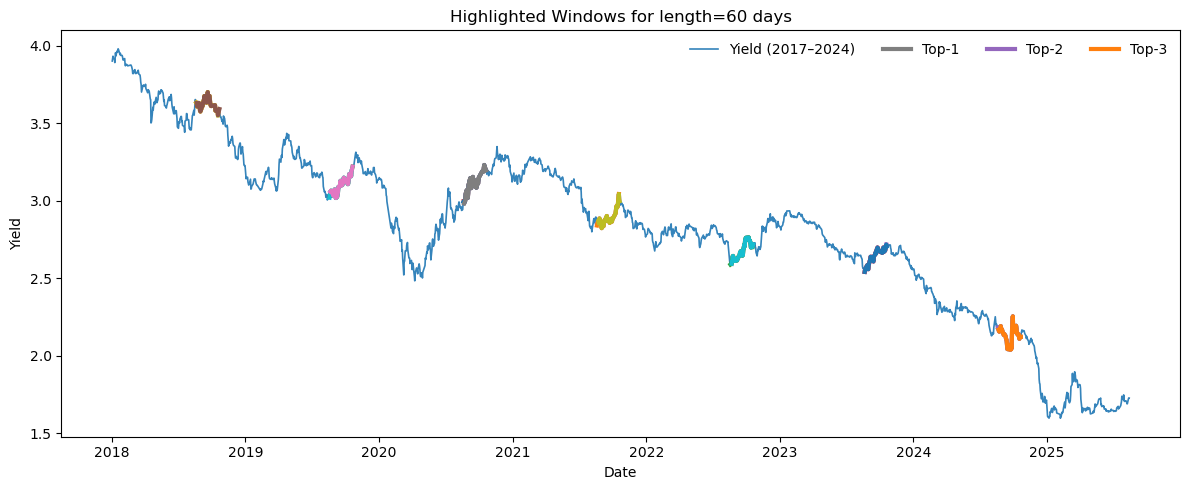

[ok] 已保存：top10_windows_by_length\highlight_len_90.png


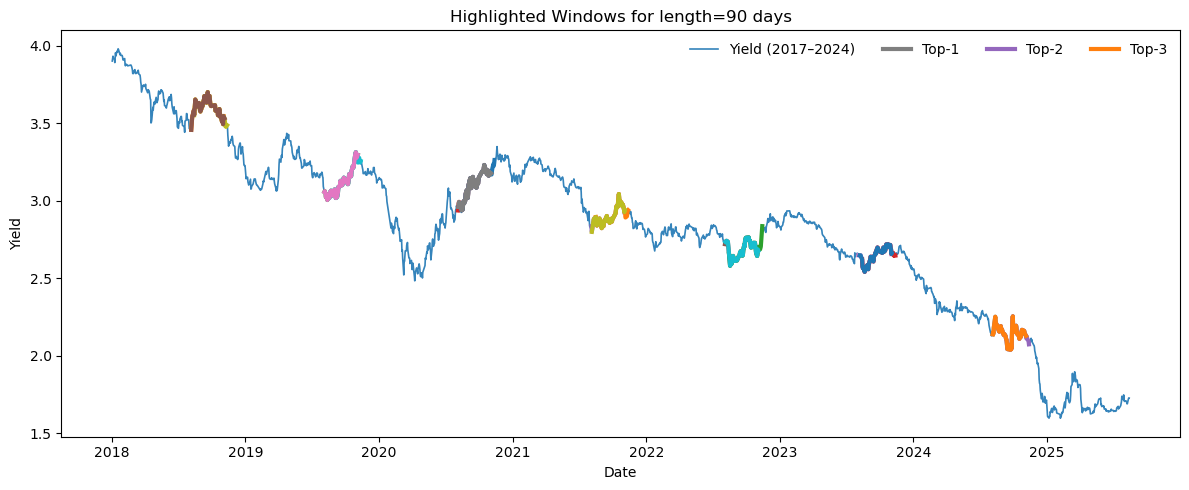

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_per_length(
    df_raw: pd.DataFrame,
    paths_dir: str = "top10_windows_by_length",
    lengths=(3,10,15,30,60,90),
    ranks=(0,1,2),               # 要高亮的Top名次；(0,)表示只Top-1
    linewidth_base=1.2,
    linewidth_highlight=3.0,
    alpha_base=0.9,
    alpha_highlight=1.0,
    save=True
):
    data = df_raw.copy()
    data['date'] = pd.to_datetime(data['date']).dt.tz_localize(None)
    data = data.sort_values('date')

    outdir = Path(paths_dir)
    outdir.mkdir(parents=True, exist_ok=True)

    for L in lengths:
        topfile   = outdir / f"top10_len_{L}.xlsx"
        pathfile  = outdir / f"paths_len_{L}.xlsx"
        if not topfile.exists() or not pathfile.exists():
            print(f"[warn] 跳过 length={L}（缺少 {topfile.name} 或 {pathfile.name}）")
            continue

        top_df   = pd.read_excel(topfile, parse_dates=['start_2017'])
        paths_df = pd.read_excel(pathfile, parse_dates=['start_aligned','end_aligned'])

        # 选取要高亮的Top-n窗口（按名次挑 start_2017）
        chosen_starts = []
        for r in ranks:
            if r < len(top_df):
                chosen_starts.append(top_df.iloc[r]['start_2017'].date())
        chosen_starts = set(chosen_starts)

        if not chosen_starts:
            print(f"[warn] length={L} 未取到任何Top窗口")
            continue

        # 过滤对应窗口的逐年区间
        paths_df['start_2017'] = pd.to_datetime(paths_df['start_2017']).dt.date
        paths_df = paths_df[paths_df['start_2017'].isin(chosen_starts)]

        # 画图：底图=整段收益率一条线；高亮=不同名次不同颜色
        plt.figure(figsize=(12, 5))
        # 底图（单色/默认颜色），只画一次
        plt.plot(data['date'], data['yield'],
                 linewidth=linewidth_base, alpha=alpha_base, label='Yield (2017–2024)')

        # 一个名次一组颜色（使用matplotlib默认循环色）
        # 为了稳定映射：rank -> color，按 ranks 顺序循环
        for idx, r in enumerate(ranks):
            # 找到该 rank 对应的 start_2017（可能多个length不足n会跳过）
            if r >= len(top_df): 
                continue
            this_start = top_df.iloc[r]['start_2017'].date()
            sub = paths_df[paths_df['start_2017'] == this_start]

            # 叠加所有年份的区间段
            for _, row in sub.iterrows():
                s = row['start_aligned']
                e = row['end_aligned']
                if pd.isna(s) or pd.isna(e):
                    continue
                seg = data[(data['date'] >= s) & (data['date'] <= e)]
                if seg.empty:
                    continue
                # 不手动指定颜色，交给matplotlib按不同label自动配色
                plt.plot(seg['date'], seg['yield'],
                         linewidth=linewidth_highlight, alpha=alpha_highlight,
                         label=f"Top-{r+1}")

        # 去重图例（Top-1/Top-2…只出现一次）
        handles, labels = plt.gca().get_legend_handles_labels()
        uniq = dict(zip(labels, handles))
        plt.legend(uniq.values(), uniq.keys(), frameon=False, ncol=4)

        plt.title(f"Highlighted Windows for length={L} days")
        plt.xlabel("Date"); plt.ylabel("Yield")
        plt.tight_layout()

        if save:
            png_path = outdir / f"highlight_len_{L}.png"
            plt.savefig(png_path, dpi=150)
            print(f"[ok] 已保存：{png_path}")

        plt.show()


# ===== 用法 =====
df_raw = pd.read_excel('中债国债到期收益率_10年.xlsx')  # 两列：date, yield
plot_per_length(
    df_raw,
    paths_dir="top10_windows_by_length",
    lengths=(3,10,15,30,60,90),
    ranks=(0,1,2),   # 每个length分别高亮Top-1/2/3
    save=True
)

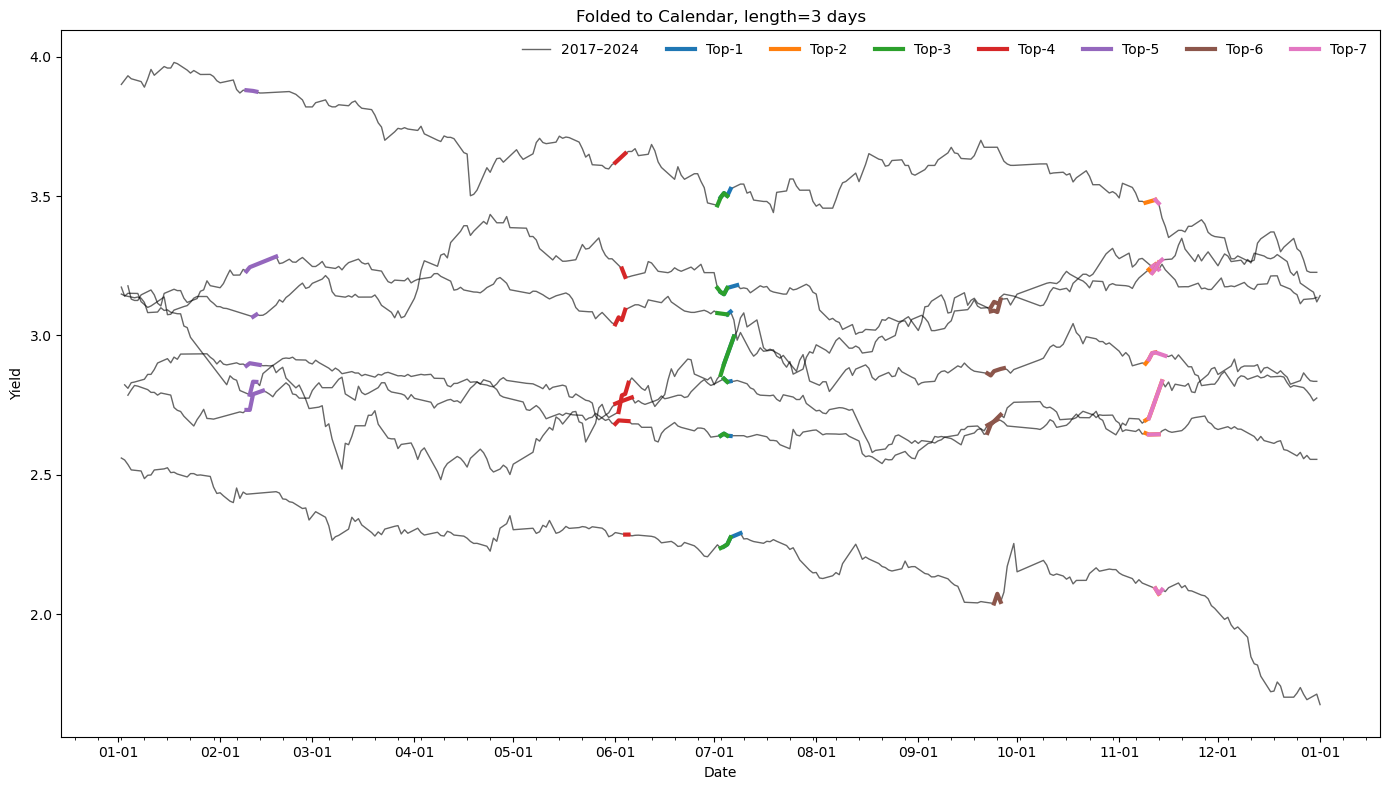

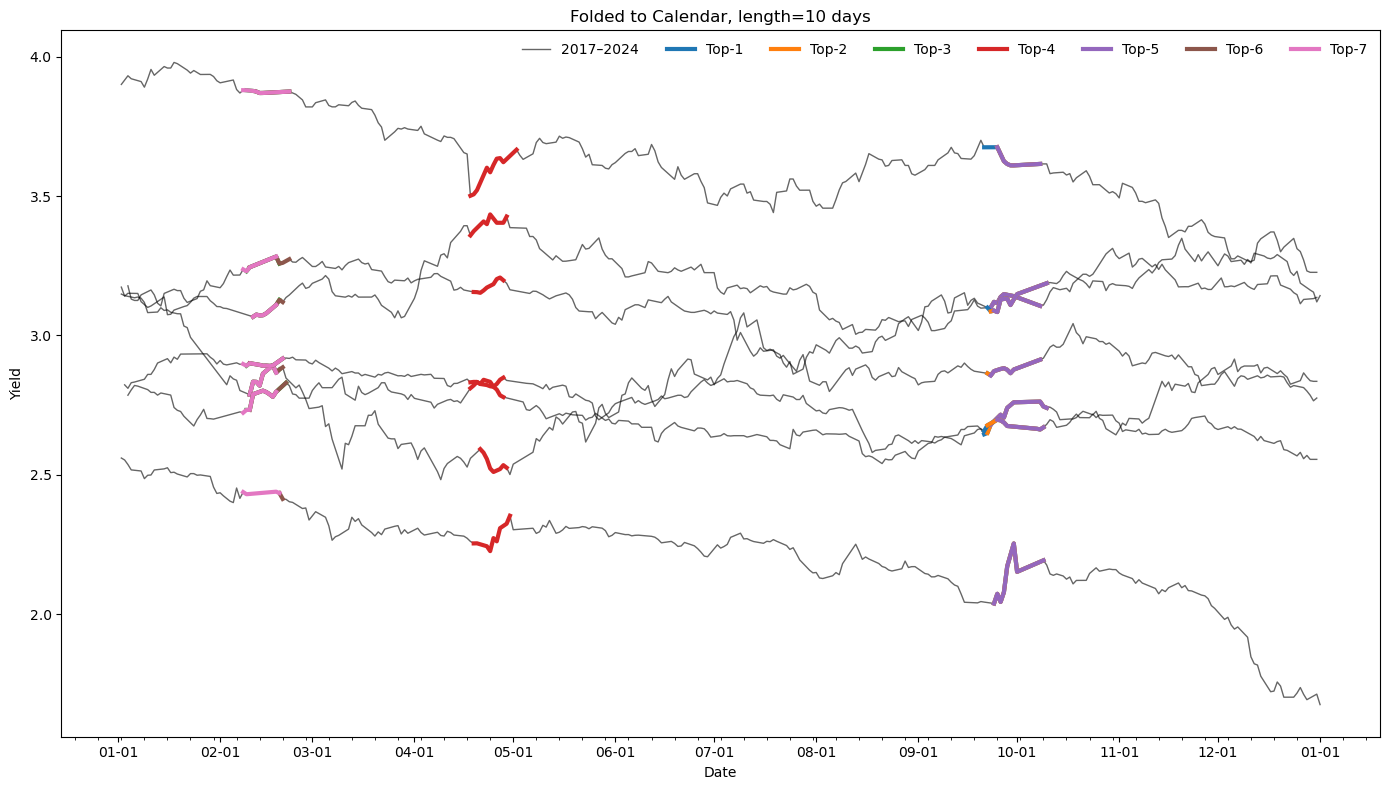

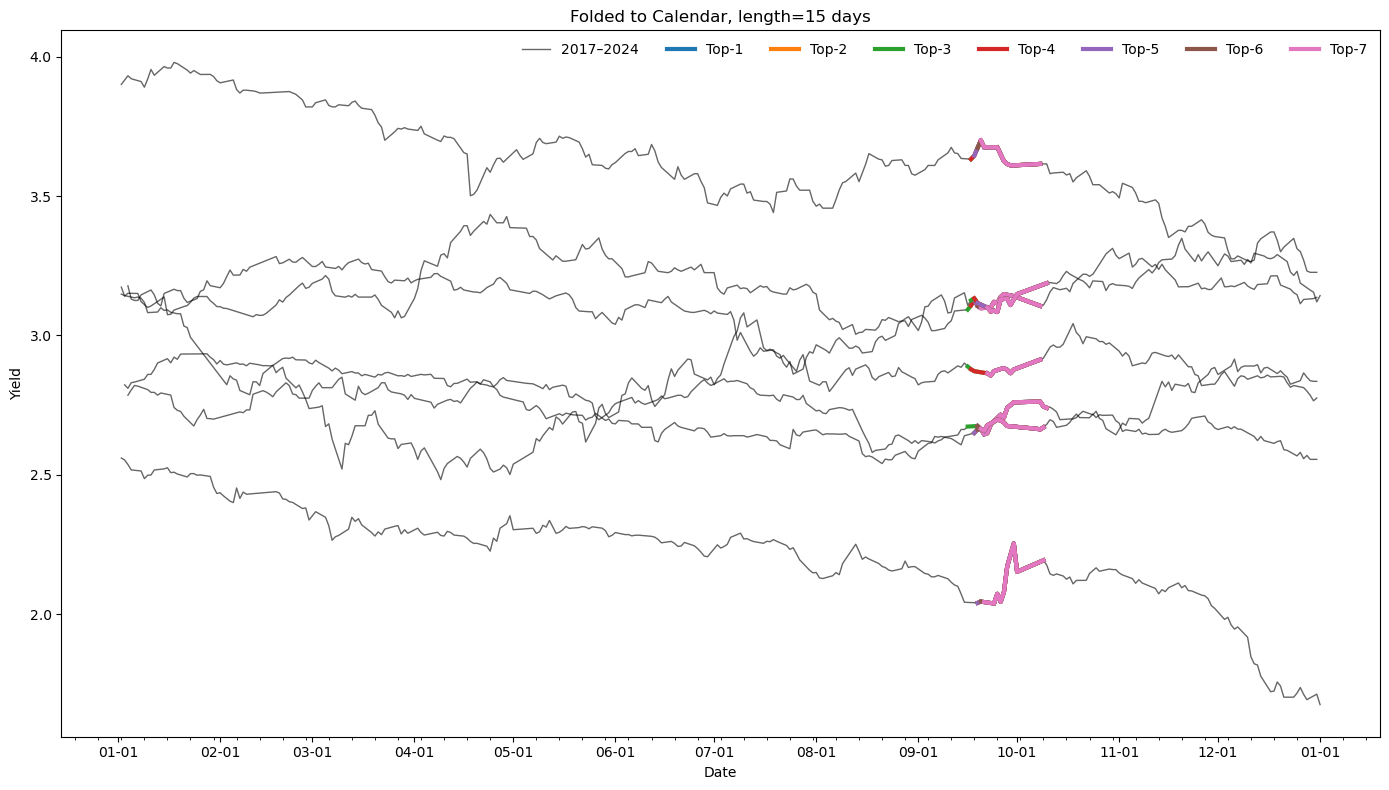

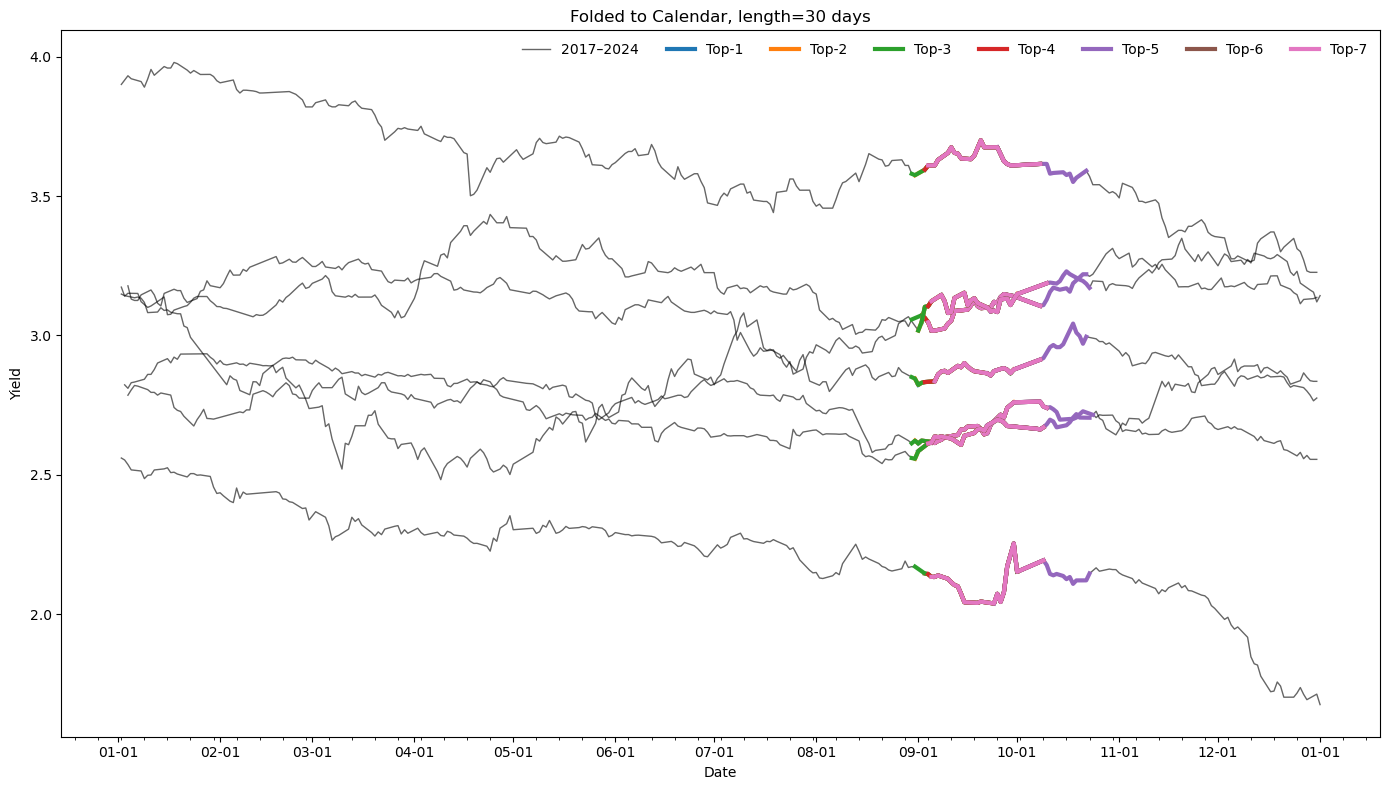

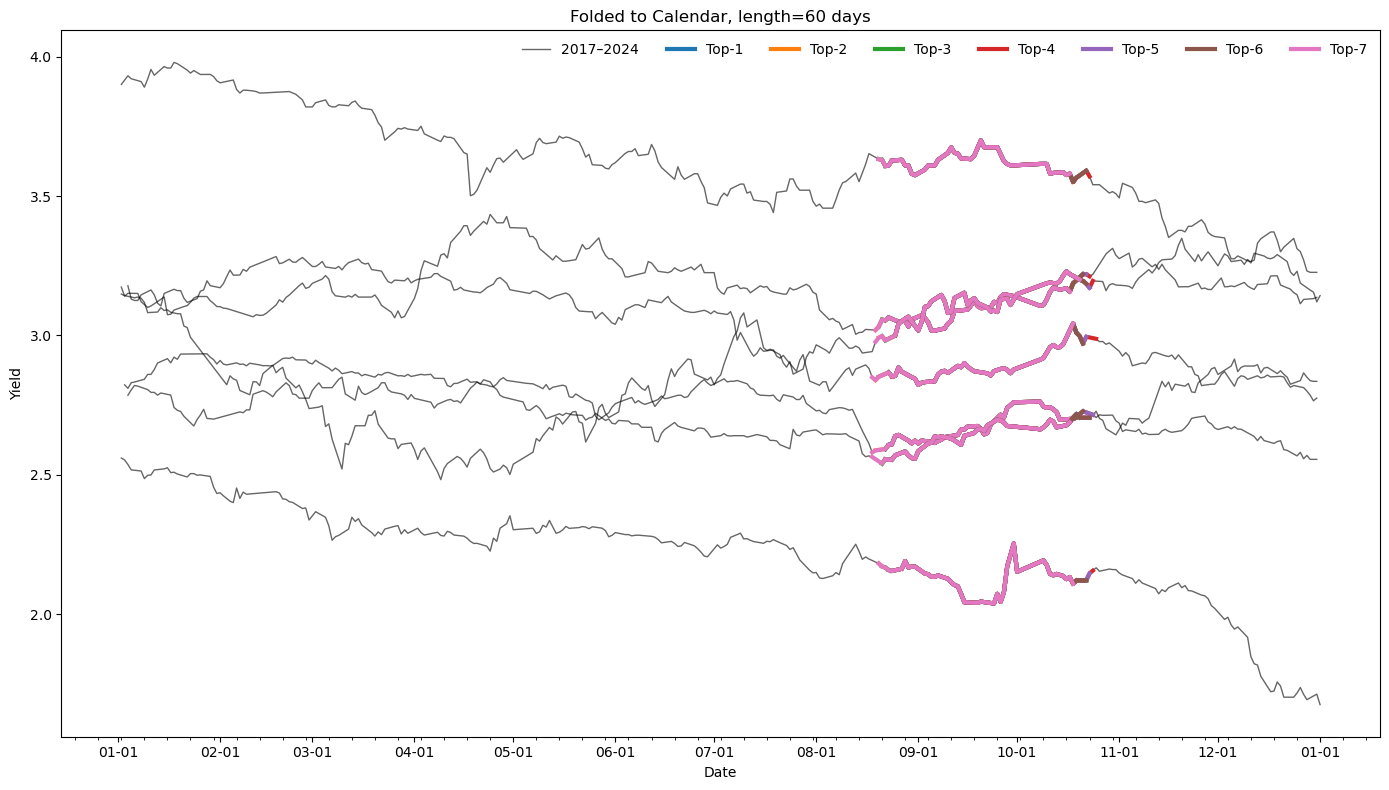

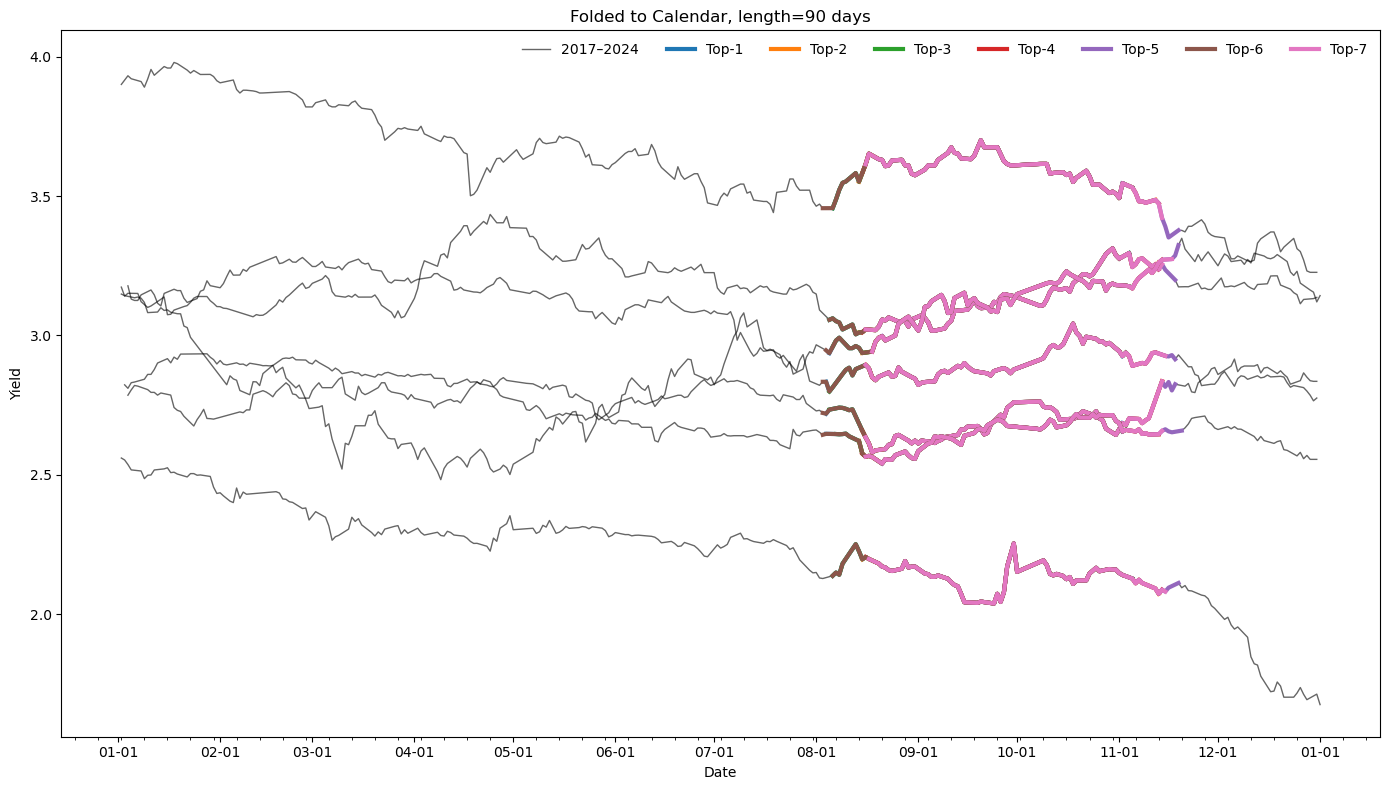

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.dates as mdates

DUMMY_YEAR = 2001  # 非闰年，作为“折叠后的”横轴年份

def _prep_folded(df_raw: pd.DataFrame):
    """去掉 2/29；生成 day_of_year；返回排好序的数据。"""
    df = df_raw.copy()
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    df = df[~((df['date'].dt.month == 2) & (df['date'].dt.day == 29))].copy()
    df['doy']  = df['date'].dt.dayofyear
    df['year'] = df['date'].dt.year
    df = df.sort_values('date')
    return df

def doy_to_dummy_date(doy: int) -> pd.Timestamp:
    """把年内日序映射到 DUMMY_YEAR 的真实日期，便于用日期刻度显示。"""
    return pd.Timestamp(DUMMY_YEAR, 1, 1) + pd.Timedelta(days=int(doy)-1)

def plot_folded_by_date_with_crossyear(
    df_raw: pd.DataFrame,
    length: int,
    paths_dir: str = "top10_windows_by_length",
    ranks=(0,1,2),          # 选哪些 Top（0=Top-1）
    figsize=(14, 8),        # 提高高度以减少重叠
    base_alpha=0.6,         # 底图每年黑线透明度
    base_lw=1.0,            # 底图线宽
    hl_lw=3.0               # 高亮线宽
):
    # 1) 数据准备（折叠到 DOY）
    data = _prep_folded(df_raw)
    years = [y for y in sorted(data['year'].unique()) if 2017 <= y <= 2024]

    # 读取 Top 与路径
    topfile  = Path(paths_dir) / f"top10_len_{length}.xlsx"
    pathfile = Path(paths_dir) / f"paths_len_{length}.xlsx"
    if not topfile.exists() or not pathfile.exists():
        raise FileNotFoundError(f"缺少 {topfile} 或 {pathfile}")

    top_df   = pd.read_excel(topfile, parse_dates=['start_2017'])
    paths_df = pd.read_excel(pathfile, parse_dates=['start_aligned','end_aligned'])

    # 删除闰日并转 DOY
    paths_df = paths_df[
        ~((paths_df['start_aligned'].dt.month == 2) & (paths_df['start_aligned'].dt.day == 29))
        & ~((paths_df['end_aligned'].dt.month   == 2) & (paths_df['end_aligned'].dt.day   == 29))
    ].copy()
    paths_df['doy_s'] = paths_df['start_aligned'].dt.dayofyear.astype(int)
    paths_df['doy_e'] = paths_df['end_aligned'].dt.dayofyear.astype(int)
    paths_df['start_2017'] = pd.to_datetime(paths_df['start_2017']).dt.date

    # 选 Top 组合（同名 top：按起点）
    chosen_starts = []
    for r in ranks:
        if r < len(top_df):
            chosen_starts.append(top_df.iloc[r]['start_2017'].date())
    chosen_starts = list(dict.fromkeys(chosen_starts))
    if not chosen_starts:
        raise ValueError("未选到任何 Top 组合")
    paths_df = paths_df[paths_df['start_2017'].isin(chosen_starts)]

    # rank -> 固定颜色；start_2017 -> rank
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    rank_to_color = {r: color_cycle[i % len(color_cycle)] for i, r in enumerate(ranks)}
    start_to_rank = {top_df.iloc[r]['start_2017'].date(): r for r in ranks if r < len(top_df)}

    # 2) 画图：x 轴为“虚拟年份”的日期（只有 2001-01-01..2001-12-31）
    plt.figure(figsize=figsize)

    # 底图：每年一条黑线（折叠到 DOY 再映射到 DUMMY_YEAR 的日期）
    for y in years:
        sub = data[data['year'] == y].copy()
        if sub.empty: 
            continue
        sub['xdate'] = sub['doy'].apply(doy_to_dummy_date)
        plt.plot(sub['xdate'], sub['yield'], color='black', alpha=base_alpha, linewidth=base_lw)

    # 高亮：对每年对应 DOY 区间加粗并着色；若跨年则拆成两段
    for y in years:
        sub_year = data[data['year'] == y]
        if sub_year.empty:
            continue
        sub_year = sub_year.assign(xdate=sub_year['doy'].apply(doy_to_dummy_date))
        p_y = paths_df[paths_df['year'] == y]
        for _, row in p_y.iterrows():
            s, e = int(row['doy_s']), int(row['doy_e'])
            start_key = row['start_2017']
            r = start_to_rank.get(start_key, None)
            if r is None: 
                continue
            color = rank_to_color[r]

            # 不跨年：直接 [s..e]
            if e >= s:
                seg = sub_year[(sub_year['doy'] >= s) & (sub_year['doy'] <= e)]
                if not seg.empty:
                    plt.plot(seg['xdate'], seg['yield'], color=color, linewidth=hl_lw)
            else:
                # 跨年：拆成 [s..365] 与 [1..e]
                seg1 = sub_year[(sub_year['doy'] >= s) & (sub_year['doy'] <= 365)]
                seg2 = sub_year[(sub_year['doy'] >= 1) & (sub_year['doy'] <= e)]
                if not seg1.empty:
                    plt.plot(seg1['xdate'], seg1['yield'], color=color, linewidth=hl_lw)
                if not seg2.empty:
                    plt.plot(seg2['xdate'], seg2['yield'], color=color, linewidth=hl_lw)

    # 图例（不在折线上写文字）
    handles = [plt.Line2D([0],[0], color='black', lw=base_lw, alpha=base_alpha, label='2017–2024')]
    for r in ranks:
        handles.append(plt.Line2D([0],[0], color=rank_to_color[r], lw=hl_lw, label=f"Top-{r+1}"))
    # 画完所有线之后、plt.legend() 之前，加：
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())           # 每月一个主刻度
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())         # 可选：周为次刻度
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')) # 只显示 MM-DD
    # 可选：避免自动把年份带回来
    for label in ax.get_xticklabels():
        label.set_rotation(0)
    plt.legend(handles=handles, frameon=False, ncol=len(handles))

    plt.title(f"Folded to Calendar, length={length} days")
    plt.xlabel("Date")   # 横轴是真实日期，但都是 2001 年
    plt.ylabel("Yield")
    plt.tight_layout()
    plt.show()


# ===== 用法：每个 length 单独画 =====
df_raw = pd.read_excel('中债国债到期收益率_10年.xlsx')  # 两列：date, yield
for L in (3, 10, 15, 30, 60, 90):
    plot_folded_by_date_with_crossyear(
        df_raw,
        length=L,
        paths_dir="top10_windows_by_length",
        ranks=(0,1,2,3,4,5,6),      # 只看Top-1就改成 (0,)
        figsize=(14, 8)     # 高一些，减少重叠
    )
